### what is SkimLit

实质上是一种Seq2seq的模型，将医学论文的摘要进行总结的模型。将每一个段落或者句子，进行总结描述，是哪一种内容，也是一种多分类问题。

SkimLit 使用迁移学习的方法，通过微调预训练的语言模型（如BERT或RoBERTa）来进行科学文献的摘要生成。它的训练数据通常包括科学期刊中的摘要-全文对，以及额外的摘要摘要对，以便进行监督学习。

SkimLit 的应用领域主要集中在科学研究和学术出版领域，帮助研究人员更有效地处理和理解大量的学术文献，以便快速获取信息和洞见。

该项目使用的[数据集](https://github.com/Franck-Dernoncourt/pubmed-rct.git)是已经被分割标注好了的数据，很干净，但是实际上如果自己做的话需要很多的前置工作。

### Get the data

In [7]:
# Check for GPU
!nvidia-smi -L

zsh:1: command not found: nvidia-smi


In [43]:
# !pip install tensorflow-macos
# !pip install tensorflow-metal
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 5.52 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [9]:
# Check what files are in the PubMed_20K dataset 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt   test.txt  train.txt


In [14]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [15]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [16]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.
  
  Args:
      filename: a string containing the target filepath to read.
  
  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [17]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [18]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [19]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [20]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [21]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [22]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

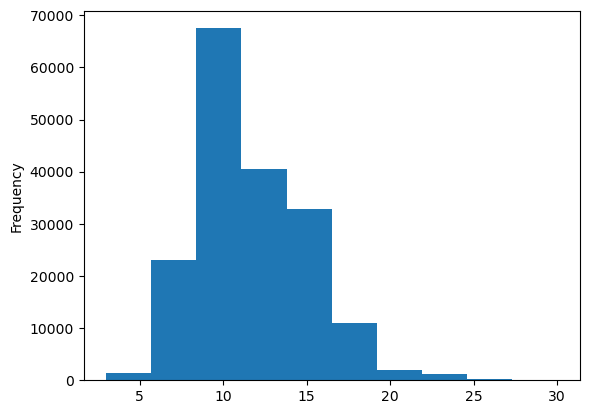

In [25]:
train_df.total_lines.plot.hist();

In [26]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [27]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [28]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/Users/sallyw/machine-learning-lab/mlztm/env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [29]:
# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [30]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Model0: baseline

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

In [32]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [33]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [34]:
# import helper function
from helper_functions import calculate_results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Preparing for data vectorization and embedding

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [37]:
# how long is each lines in avarage
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([1.5999e+05, 1.8760e+04, 1.1510e+03, 9.9000e+01, 2.8000e+01,
        1.0000e+01, 2.0000e+00]),
 array([  1.        ,  43.14285714,  85.28571429, 127.42857143,
        169.57142857, 211.71428571, 253.85714286, 296.        ]),
 <BarContainer object of 7 artists>)

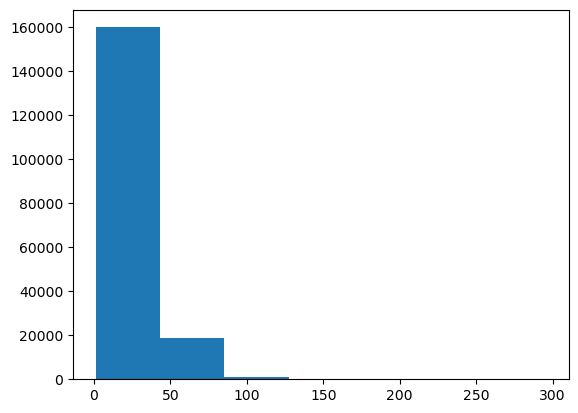

In [38]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7)

In [39]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [40]:
max(sent_lens)

296

### Create text vectorizer

In [41]:
# how many words are in the vocabulary
max_tokens = 68000

In [44]:
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=output_seq_len)

In [45]:
# adapt vectorizer to train_sentences
text_vectorizer.adapt(train_sentences)

2024-02-09 17:12:52.154376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [47]:
# test out
import random
target_sentence = random.choice(train_sentences)
print(f"Target sentence is : {target_sentence}")
print(f"Length of the sentence is : {len(target_sentence.split())}")
print(f"Text vectorization: {text_vectorizer([target_sentence])}")

Target sentence is : we conducted a randomized control trial in which physicians-in-training were randomized to an auc-based educational intervention or a control group at an academic medical center in boston , massachusetts .
Length of the sentence is : 30
Text vectorization: [[   43   198     8    29    35    32     5   126 25183     9    29     6
     26 27392   904    38    16     8    35    13    15    26  1562   274
    768     5  7402  8035     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [49]:
# how many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}")
print(f"Top 5 common words: {rct_20k_text_vocab[:5]}")
print(f"Least 5 common words: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Top 5 common words: ['', '[UNK]', 'the', 'and', 'of']
Least 5 common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [50]:
# get the config of the text_vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

- Vectorization only make the sentences into numbers but can not show the relationship of the words.
- so we need Embedding.

### Create Embedding layer
input_dim define the size of vocabulary, and output_dim defines the dimension of the embedding output.

In [51]:
# create the embedding layer
token_embed = layers.Embedding(
    input_dim=len(rct_20k_text_vocab),
    output_dim=128,
    mask_zero=True,
    name="token_embedding"
)

In [52]:
# Show example embedding
print(f"Target_sentence: {target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Vectorized target sentence: {vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Embedded sentence: {embedded_sentence}, with shape of {embedded_sentence.shape}")

Target_sentence: we conducted a randomized control trial in which physicians-in-training were randomized to an auc-based educational intervention or a control group at an academic medical center in boston , massachusetts .
Vectorized target sentence: [[   43   198     8    29    35    32     5   126 25183     9    29     6
     26 27392   904    38    16     8    35    13    15    26  1562   274
    768     5  7402  8035     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Embedded sentence: [[[ 0.01562114 -0.02947158 -0.04362962 ...  0.00153196  0.02208545
    0.0051954 ]
  [-0.03097613  0.02665827 -0.01545527 ...  0.01333607 -0.04281775
   -0.00745289]
  [ 0.02958253 -0.0265415  -0.029838   ... -0.03157397 -0.03163259
    0.00769433]
  ...
  [-0.04596529 -0.0396254  -0.0310029  ...  0.04357486  0.02015528
   -0.012834  ]
  [-0.04596529 -0.0396254  -0.0310029  ...  0.0435

In [54]:
vectorized_sentence.shape, embedded_sentence.shape

(TensorShape([1, 55]), TensorShape([1, 55, 128]))

- 55 is the output sentence length setted by text_vectorizer
- 128 is the output_dim setted by token_embed

### Create datasets (check the doc!!)

In [55]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [56]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

The models will like :

Input(text) --> Tokenize --> Embedding --> Layers --> Output(label probalibity)

build model --> train model --> evaluate model

### Model1: Conv1D with token embeddings

In [60]:
# create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(
    64,
    kernel_size=5,
    padding="same",
    activation="relu"
)(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# compile
model_1.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"]
)

In [61]:
# get summary of Conv1D model
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 55)                0         
 Vectorization)                                                  
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d_3 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_3  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                           

- About use the subset:
- training data contains nearly 200000 sentences, fitting will take a long time. So to keep out experiments swift, run them on a subset of the training dataset.
- only use the first 10% of batches(about 18000 samples) of the training set to train on and the first 10% of batches from the validation set to validate on.

In [62]:
# fit the model
model_1_history = model_1.fit(
    train_dataset,
    steps_per_epoch=int(0.1 * len(train_dataset)),
    epochs=3,
    validation_data=valid_dataset,
    validation_steps=int(0.1 * len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 27s 39ms/step - loss: 0.9144 - accuracy: 0.6392 - val_loss: 0.6871 - val_accuracy: 0.7380
Epoch 2/3
562/562 [==============================] - 20s 36ms/step - loss: 0.6584 - accuracy: 0.7552 - val_loss: 0.6316 - val_accuracy: 0.7713
Epoch 3/3
562/562 [==============================] - 20s 36ms/step - loss: 0.6184 - accuracy: 0.7745 - val_loss: 0.5979 - val_accuracy: 0.7839


In [63]:
# evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 9s 10ms/step - loss: 0.5986 - accuracy: 0.7849


[0.5985892415046692, 0.7848867774009705]

In [64]:
# make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 3ms/step


array([[4.37065840e-01, 1.55582607e-01, 8.47149715e-02, 2.99972326e-01,
        2.26642415e-02],
       [4.91023898e-01, 2.28664279e-01, 1.27205839e-02, 2.60172248e-01,
        7.41901621e-03],
       [1.30823761e-01, 5.82501013e-03, 1.32411532e-03, 8.62003446e-01,
        2.36797605e-05],
       ...,
       [4.30040291e-06, 7.55501795e-04, 6.77421573e-04, 3.50593223e-06,
        9.98559296e-01],
       [5.96649647e-02, 4.38765347e-01, 1.04137465e-01, 6.98668063e-02,
        3.27565432e-01],
       [1.74039513e-01, 6.73732340e-01, 4.93405238e-02, 3.93536873e-02,
        6.35339543e-02]], dtype=float32)

In [65]:
# convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [66]:
# calculate model_1 results
model_1_results = calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_1_preds
)
model_1_results

{'accuracy': 78.48867999470409,
 'precision': 0.78126643061663,
 'recall': 0.7848867999470409,
 'f1': 0.7822280729042087}

### Model2: Feature extraction with pretrained token embeddings

inputs(string) --> pretrained embeddings from tensorflow hub(Universe sentence encoder)

transfer learning

In [69]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [68]:
!pip3 install tensorflow_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 609.1 kB/s eta 0:00:00a 0:00:01


In [70]:
# test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence :\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}(truncated output)\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence :
after an @-week baseline period , patients were randomized to once-daily placebo ( n = @ ) , esl @ mg ( n = @ ) , or esl @,@ mg ( n = @ ) .

Sentence after embedding:
[-0.01201206 -0.03525863  0.04698653 -0.02744422 -0.06384209  0.03896685
  0.03069838 -0.00859197 -0.05859613 -0.01284317  0.06522817  0.00561847
  0.06010677  0.03959933  0.04121524  0.0124637  -0.07487276 -0.02542698
 -0.02706639 -0.06882976  0.073079   -0.01362267 -0.05067691  0.02234137
 -0.03860472 -0.03533686 -0.00754866 -0.0507905  -0.0065466  -0.06792147](truncated output)

Length of sentence embedding:
512


In [72]:
# build and fit the model from USE by transfer learning
# define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
# tokenize text and create embedding
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# here can be add more layers if need to 
outputs = layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)

# compile the model
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"]
)

In [73]:
# get the summary
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


there are a hole banch of parameters, but most of them will not be trained because we set trainable as False.

In [74]:
# fit feature extractor model for 3 epochs
model_2.fit(
    train_dataset,
    steps_per_epoch=int(0.1 * len(train_dataset)),
    epochs=3,
    validation_data=valid_dataset,
    validation_steps=int(0.1 * len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 52s 90ms/step - loss: 0.9131 - accuracy: 0.6537 - val_loss: 0.8105 - val_accuracy: 0.6882
Epoch 2/3
562/562 [==============================] - 43s 76ms/step - loss: 0.7852 - accuracy: 0.6948 - val_loss: 0.7829 - val_accuracy: 0.6958
Epoch 3/3
562/562 [==============================] - 52s 93ms/step - loss: 0.7855 - accuracy: 0.7000 - val_loss: 0.7850 - val_accuracy: 0.6981


In [76]:
# evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 84s 89ms/step - loss: 0.7805 - accuracy: 0.6982


[0.7805309891700745, 0.6981993913650513]

In [77]:
# make predictions with model 2
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 84s 88ms/step


array([[0.42271605, 0.37420774, 0.00191271, 0.19273399, 0.00842952],
       [0.3587523 , 0.5066348 , 0.00143363, 0.1312234 , 0.00195592],
       [0.20703864, 0.20470196, 0.01401198, 0.5201336 , 0.05411379],
       ...,
       [0.00374495, 0.00718034, 0.0531804 , 0.00165737, 0.93423694],
       [0.0062439 , 0.04793263, 0.20905368, 0.00232448, 0.7344454 ],
       [0.12665541, 0.138025  , 0.6488827 , 0.0046369 , 0.08180003]],
      dtype=float32)

In [78]:
# convert the predictions to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [79]:
# calculate results
model_2_results = calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_2_preds
)
model_2_results

{'accuracy': 69.81993909704754,
 'precision': 0.6974501497895977,
 'recall': 0.6981993909704753,
 'f1': 0.6948814977781582}

### Model3: Conv1D with character embeddings

字符级别的分词，更加细化了，但是一共只有26个字母而已，这样其实是不是也是一种简化？还是内部更加复杂？

In [80]:
# make function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

# test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

'a f t e r   a n   @ - w e e k   b a s e l i n e   p e r i o d   ,   p a t i e n t s   w e r e   r a n d o m i z e d   t o   o n c e - d a i l y   p l a c e b o   (   n   =   @   )   ,   e s l   @   m g   (   n   =   @   )   ,   o r   e s l   @ , @   m g   (   n   =   @   )   .'

In [81]:
# split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])
print(val_chars[0])
print(test_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .
i g e   s e n s i t i z a t i o n   t o   a s p e r g i l l u s   f u m i g a t u s   a n d   a   p o s i t i v e   s p u t u m   f u n g a l   c u l t u r e   r e s u l t   a r e   c o m m o n   i n   p a t i e n t s   w i t h   r e f r a c t o r y   a s t h m a   .
t h i s   s t u d y   a n a l y z e d   l i v e r   f u n c t i o n   a b n o r m a l i t i e s   i n   h e a r t   f a i l u r e   p a t i e n t s   a d m i t t e d   w 

In [82]:
# what is the average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

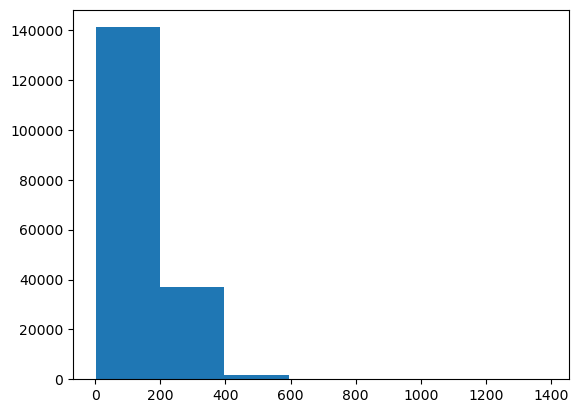

In [83]:
# check the distribution of sequences at character-level
plt.hist(char_lens, bins=7)

In [84]:
# find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [85]:
# get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [86]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # space and OOV token
NUM_CHAR_TOKENS

70

In [88]:
# create char-level token vectorizer instance
char_vectorizer = TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length=output_seq_char_len,
    standardize="lower_and_strip_punctuation",
    name="char_vectorizer"
)

In [89]:
# adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [91]:
# check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [93]:
# test on random sentence
random_train_chars = random.choice(train_chars)
print(f"Charified text: \n{random_train_chars}\n")
print(f"Length of chars: {len(random_train_chars.split())}\n")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars :\n{vectorized_chars}\n")
print(f"Length of vectorized chars: {len(vectorized_chars[0])}")

Charified text: 
p o s t o p e r a t i v e l y   ,   t h e   r a t e   o f   c h a n g e   i n   c e n t r a l   c o r n e a l   t h i c k n e s s   a n d   a n t e r i o r   c h a m b e r   i n f l a m m a t i o n   a t   d a y s   @   a n d   @   ,   e n d o t h e l i a l   c e l l   d e n s i t y   a t   @   m o n t h s   ,   a n d   c o r n e a l   c l a r i t y   o n   d a y   @   w e r e   c o m p a r e d   .

Length of chars: 166

Vectorized chars :
[[14  7  9  3  7 14  2  8  5  3  4 21  2 12 19  3 13  2  8  5  3  2  7 17
  11 13  5  6 18  2  4  6 11  2  6  3  8  5 12 11  7  8  6  2  5 12  3 13
   4 11 23  6  2  9  9  5  6 10  5  6  3  2  8  4  7  8 11 13  5 15 22  2
   8  4  6 17 12  5 15 15  5  3  4  7  6  5  3 10  5 19  9  5  6 10  2  6
  10  7  3 13  2 12  4  5 12 11  2 12 12 10  2  6  9  4  3 19  5  3 15  7
   6  3 13  9  5  6 10 11  7  8  6  2  5 12 11 12  5  8  4  3 19  7  6 10
   5 19 20  2  8  2 11  7 15 14  5  8  2 10  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  

In [94]:
# create the embedding layer
char_embed = layers.Embedding(
    input_dim=NUM_CHAR_TOKENS,
    output_dim=25,
    mask_zero=False,
    name="char_embed"
)

In [96]:
# test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
p o s t o p e r a t i v e l y   ,   t h e   r a t e   o f   c h a n g e   i n   c e n t r a l   c o r n e a l   t h i c k n e s s   a n d   a n t e r i o r   c h a m b e r   i n f l a m m a t i o n   a t   d a y s   @   a n d   @   ,   e n d o t h e l i a l   c e l l   d e n s i t y   a t   @   m o n t h s   ,   a n d   c o r n e a l   c l a r i t y   o n   d a y   @   w e r e   c o m p a r e d   .

Embedded chars (after vectorization and embedding):
[[[ 0.00364358  0.04845798 -0.00674721 ... -0.02329942 -0.00302293
   -0.01582553]
  [ 0.04322224 -0.03558048  0.02255918 ... -0.0383814  -0.03017029
   -0.04810159]
  [-0.0372312  -0.00130381  0.02208276 ...  0.02525742  0.03226322
   -0.01807858]
  ...
  [-0.03350841  0.03933946  0.03929074 ...  0.03764829  0.03092643
   -0.00914077]
  [-0.03350841  0.03933946  0.03929074 ...  0.03764829  0.03092643
   -0.00914077]
  [-0.03350841  0.03933946  0.03929074 ...  0.03764829  0.03092643
   -

In [97]:
# build the model
# input (character-level text) --> tokenize --> embedding --> layers
# make conv1D on chars only
inputs = layers.Input(shape=(1,),dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(
    64,
    kernel_size=5,
    padding="same",
    activation="relu"
)(char_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(
    inputs=inputs,
    outputs=outputs,
    name="model_3_conv1D_char_embedding"
)

# compile model 
model_3.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"]
)

In [98]:
# check the summary of model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_4 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_average_pooling1d_4  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_6 (Dense)             (None, 5

In [100]:
# char level batch need to be create
train_char_dataset = tf.data.Dataset.from_tensor_slices(
    (train_chars, train_labels_one_hot)
).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices(
    (val_chars, val_labels_one_hot)
).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [101]:
# fit the model on chars only with 10% data
model_3_history = model_3.fit(
    train_char_dataset,
    steps_per_epoch=int(0.1 * len(train_char_dataset)),
    epochs=3,
    validation_data=val_char_dataset,
    validation_steps=int(0.1 * len(val_char_dataset))
)

Epoch 1/3
562/562 [==============================] - 24s 40ms/step - loss: 1.4617 - accuracy: 0.3376 - val_loss: 1.4150 - val_accuracy: 0.3983
Epoch 2/3
562/562 [==============================] - 21s 38ms/step - loss: 1.3735 - accuracy: 0.4122 - val_loss: 1.3389 - val_accuracy: 0.4302
Epoch 3/3
562/562 [==============================] - 22s 38ms/step - loss: 1.3283 - accuracy: 0.4488 - val_loss: 1.3135 - val_accuracy: 0.4408


In [102]:
# evaluate model 3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 16s 17ms/step - loss: 1.3118 - accuracy: 0.4480


[1.3117729425430298, 0.44800078868865967]

In [103]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 4s 4ms/step


array([[0.18311791, 0.24895434, 0.24399595, 0.1863451 , 0.13758667],
       [0.1103473 , 0.16169944, 0.185353  , 0.06094738, 0.48165292],
       [0.10022524, 0.15889555, 0.4032759 , 0.1105636 , 0.2270397 ],
       ...,
       [0.06701434, 0.11186036, 0.21072549, 0.04220208, 0.5681977 ],
       [0.04883656, 0.10094733, 0.16332415, 0.04168338, 0.64520854],
       [0.14379421, 0.18027633, 0.18862236, 0.0676598 , 0.4196473 ]],
      dtype=float32)

In [104]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 4, 2, ..., 4, 4, 4])>

In [105]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

/Users/sallyw/machine-learning-lab/mlztm/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 44.80007943863365,
 'precision': 0.37772119906005436,
 'recall': 0.44800079438633655,
 'f1': 0.39367231056863616}

### Model4: combining pretrained token embeddings + character embeddings(hybrid embedding layer)

- create a stacked embedding to represent sequences before passing them to the sequence label prediction layer

- steps:
  1. create a token-level model like model 1
  2. create a char-level model like model 3
  3. combine (use layers.Concatenate) the outputs of 1 and 2
  4. build a series of output layers on top of 3
  5. construct a model which takes token and char-level sequences as input and produces sequence label probabilities as output

In [106]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [107]:
# get a summary
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

In [108]:
# plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [109]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.legacy.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [110]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [111]:
# check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [112]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 161s 276ms/step - loss: 0.9392 - accuracy: 0.6279 - val_loss: 0.8119 - val_accuracy: 0.6902
Epoch 2/3
562/562 [==============================] - 119s 211ms/step - loss: 0.8113 - accuracy: 0.6847 - val_loss: 0.7666 - val_accuracy: 0.7118
Epoch 3/3
562/562 [==============================] - 116s 207ms/step - loss: 0.8175 - accuracy: 0.6832 - val_loss: 0.7697 - val_accuracy: 0.7074


In [113]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 132s 139ms/step - loss: 0.7720 - accuracy: 0.7038


[0.7720068693161011, 0.7037931680679321]

In [114]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 142s 148ms/step


array([[0.42880782, 0.37506148, 0.00303074, 0.18447258, 0.00862736],
       [0.4346552 , 0.28224072, 0.00126704, 0.2807588 , 0.00107825],
       [0.27890745, 0.1417344 , 0.01373107, 0.5397887 , 0.02583842],
       ...,
       [0.00565291, 0.00919025, 0.07577018, 0.00191877, 0.9074679 ],
       [0.01116359, 0.05466448, 0.32920718, 0.00726238, 0.5977023 ],
       [0.18917415, 0.23968682, 0.44625884, 0.00845534, 0.11642484]],
      dtype=float32)

In [115]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 2])>

In [116]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 70.37931947570502,
 'precision': 0.7019032610621948,
 'recall': 0.7037931947570502,
 'f1': 0.7007302355142682}

### Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

- `line_number` col and `total_lines` col can be passed to model as a positional embedding
- turn the cols into one hot format

In [117]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [118]:
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

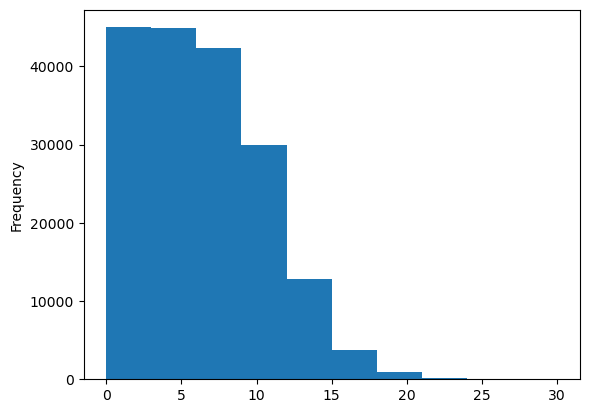

In [120]:
# check the distribution of line_number column
train_df["line_number"].plot.hist()

looking at the distribution of the line number, it looks like the majority of lines have a position of 15 or less

In [ ]:
# use Tensorflow to create one-hot-encoded tensors of line_number col
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [ ]:
# check one hot encoded line_number features shape and sample
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

In [ ]:
# how many different numbers of lines are there for "total_lines"?
train_df["total_lines"].value_counts()

In [ ]:
# check the distribution of total_lines
train_df["total_lines"].plot.hist()

In [ ]:
# check the coverage of total_lines of value 20
np.percentile(train_df.total_lines, 98)
# which value covers 98% of the samples

In [ ]:
# use Tenserflow to create one-hot encoded tensers of total_lines column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# check the sample and sample of the one hot encoded total_lines col
train_total_lines_one_hot.shape, train_total_lines_one_hot[:20]

Steps:

1. Create a token-level model (similar to model_1)
2. Create a character-level model (similar to model_3 with a slight modification to reflect the paper)
3. Create a "line_number" model (takes in one-hot-encoded "line_number" tensor and passes it through a non-linear layer)
4. Create a "total_lines" model (takes in one-hot-encoded "total_lines" tensor and passes it through a non-linear layer)
5. Combine (using layers.Concatenate) the outputs of 1 and 2 into a token-character-hybrid embedding and pass it series of output to Figure 1 and section 4.2 of Neural Networks for Joint Sentence Classification in Medical Paper Abstracts
6. Combine (using layers.Concatenate) the outputs of 3, 4 and 5 into a token-character-positional tribrid embedding
7. Create an output layer to accept the tribrid embedding and output predicted label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of 7 into a tf.keras.Model

In [ ]:
# 1. token inputs
token_input = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

# 2. char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=x)

# 4. total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs, outputs=y)

# 5. combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output, total_lines_model.output, z])

# 7. create output layer
output_layer = layers.Dense(
    5,
    activation="softmax",
    name="output_layer"
)(z)

# 8. put together model
model_5 = tf.keras.Model(
    inputs=[
        line_number_model.input,
        total_line_model.input,
        token_model.input,
        char_model.input
    ],
    outputs=output_layer
)

In [ ]:
# get a summary of token, char, and positional embedding model
model_5.summary()

In [ ]:
# plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [ ]:
# check which layers of our model are trainable or not
for layer in model_5.layers:
    print(layer, layer.trainable)

`label_smoothing` helps to regularize model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

In [ ]:
# compile token, char, positional embedding model
model_5.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer=tf.keras.optimizer.legacy.Adam(),
    metrics=["accuracy"]
)

In [ ]:
# create training and validation datasets (4 inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((
    train_line_numbers_one_hot,
    train_total_lines_one_hot,
    train_sentences,
    train_chars))
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((
    train_pos_char_token_data,
    train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((
    val_line_numbers_one_hot,
    val_total_lines_one_hot,
    val_sentences,
    val_chars
))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((
    val_pos_char_token_data,
    val_pos_char_token_labels
))
val_pos_char_token_dataset = val_pos_char_token_dataset.batcha(32).prefetch(tf.data.AUTOTUNE)

# check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

In [ ]:
# fit the token, char, and positional embedding model
history_model_5 = model_5.fit(
    train_pos_char_token_dataset,
    steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
    epochs=3,
    validation_data=val_pos_char_token_dataset,
    validation_steps=int(0.1 * len(val_pos_char_token_dataset))
)

In [ ]:
# make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

In [ ]:
# turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

In [ ]:
# calculate results of token-char-positional hybrid model
model_5_results = calculate_results(
    y_true=val_labels_encoded,
    y_pred=model_5_preds
)

### Compare model results

In [ ]:
# combine model results into Dataframe
all_model_results = pd.DataFrame({
    "baseline": baseline_results,
    "custom_token_embed_conv1d": model_1_results,
    "pretrained_token_embed": model_2_results,
    "custom_char_embed_conv1d": model_3_results,
    "hybrid_char_token_embed": model_4_results,
    "tribrid_pos_char_token_embed": model_5_results
})
all_model_results = all_model_results.transpose()
all_model_results

In [ ]:
# reduce the accuracy to same scale as other metrics
all_model_result["accuracy"] = all_model_results["accuracy"]/100

In [ ]:
# plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

In [ ]:
# sort model results by f1 score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

### Save and load best model

In [ ]:
# save model
model_5.save("skimlit_tribrid_model")

In [ ]:
# load model
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

model_path = "skimlit_tribrid_model/"

loaded_model = tf.keras.models.load_model(model_path)


In [ ]:
# make predictions with the loaded model
loaded_pred_probs = loaded_model_predict(val_pos_char_token_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

In [ ]:
# evaluate loaded model's predictions
loaded_model_results = calculate_results(
    val_labels_encoded,
    loaded_preds
)
loaded_model_results

In [ ]:
# Compare loaded model results with original trained model results (should be quite close)
np.isclose(list(model_5_results.values()), list(loaded_model_results.values()), rtol=1e-02)

### Evaluate model on test dataset

In [ ]:
# create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slice((
    test_line_numbers_one_hot,
    test_total_lines_one_hot,
    test_sentences,
    test_chars
))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slice(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# check shapes
test_pos_char_token_dataset

In [ ]:
# make predictions on the test dataset
test_pred_probs = loaded_model.predict(
    test_pos_char_token_dataset,
    verbose=1
)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

In [ ]:
# evaluate loaded model test predictions
loaded_model_test_results = calculate_results(
    y_true=test_labels_encoded,
    y_pred=test_preds
)
loaded_model_test_results

### Find most wrong

In [ ]:
# get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

In [ ]:
# create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes
test_df["pred_prob"] = tf.refuce_max(test_pred_probs, axis=1).numpy()
test_df["correct"] = test_df["prediction"] == test_df["target"]
test_df.head(20)

In [ ]:
# find top 100 most wrong samples
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

In [ ]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")